# Evalution of LLM prompts

In [132]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.schema.messages import SystemMessage
import yaml
import os
import json
import pandas as pd
from pydantic import BaseModel
import seaborn as sns
import numpy as np


In [117]:
from openai import OpenAI
import os
import yaml

# Set up your OpenAI API key
with open('openai.yaml', 'r') as f:
    config = yaml.safe_load(f)

os.environ['OPENAI_API_KEY'] = config['openai_key']

# initialise the OpenAI connection
llm = ChatOpenAI()

We define a set of criteria with which to assess the quality of prompts. Each criterion is represented as another LLM prompt which we will use, in combination with the prompt_under_evaluation, to assess the prompt.

We define a dataclass to represent the criterion (name and prompt string) and then assemble a dictionary of those for use in the next steps.

In [9]:
class EvaluationCriterion(BaseModel):
    """A named metric and the LLM prompt to use to evaluate it"""

    name: str
    prompt: str


We specify here the criteria we want to evaluate against, along with their prompt strings.

The 'relevance' and 'contextual appropriateness' metrics require additional information about the intended audience and subject, so we're not using them here because we aren't providing those things.

In [54]:
criteria = {
    'specificity': EvaluationCriterion(name='specificity', prompt='''On a scale of 0-100, evaluate the specificity of this prompt. Consider whether it clearly defines the scope of the response, including time periods, context, or the level of detail required. A score of 100 indicates precise and well-defined instructions, while a score of 0 indicates vagueness and lack of focus.'''),
    # 'relevance': EvaluationCriterion(name='relevance', prompt='''On a scale of 0-100, how well does this prompt directly address the topic or task it is intended for? A score of 100 indicates that the prompt is perfectly aligned with the task, while a score of 0 indicates that it is completely irrelevant.'''),
    'brevity': EvaluationCriterion(name='brevity', prompt='''On a scale of 0-100, how concise is this prompt? Consider whether the prompt is free of unnecessary details and uses the fewest words necessary to clearly convey the task. A score of 100 indicates that the prompt is highly concise and to the point, while a score of 0 indicates that it is overly wordy or includes irrelevant information.'''),
    # 'contextual_appropriateness': EvaluationCriterion(name='contextual_appropriateness', prompt='''On a scale of 0-100, how appropriate is this prompt for the intended audience? Consider whether the language, tone, and complexity are suitable for the audience it is meant for (e.g., technical vs. non-technical, formal vs. informal). A score of 100 indicates perfect suitability, while a score of 0 indicates that the prompt is entirely inappropriate for the audience.'''),
    'neutrality': EvaluationCriterion(name='neutrality', prompt='''On a scale of 0-100, assess the neutrality of this prompt. Evaluate whether the prompt is free from biased language or leading terms that could influence the response toward a particular viewpoint. A score of 100 indicates complete neutrality, while a score of 0 indicates strong bias.''')
}

Our test examples

In [58]:
clear_prompt = 'Describe the process of photosynthesis in plants, focusing specifically on the roles of sunlight, carbon dioxide, and chlorophyll.'
unclear_prompt = 'Talk about stupid plants and their supposed importance, which is probably not good'

In [47]:
def evaluate_prompt(prompt_under_evaluation: str, criterion: EvaluationCriterion, n: int):
    """Evaluates an LLM prompt with respect to a given criterion. The criterion is expressed in natural language and the
    method uses an LLM to do the evaluation. Because this is non-deterministic we repeat the process n times and return a vector of values."""

    # recover the evaluator prompt from the provided criterion
    evaluator_prompt = criterion.prompt

    # construct the object to send to the LLM
    # chat_template = ChatPromptTemplate([
    #     ("system", evaluator_prompt),
    #     ("human", prompt_under_evaluation),
    # ])


    chat_template = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                content=evaluator_prompt + """. Output a score only."""
            ),

            HumanMessagePromptTemplate.from_template(
                """{prompt_under_evaluation}"""
                ),
        ]
    )

    # send it to the LLM the specified number of times
    # results = [llm.invoke(chat_template).content for _ in range(n)]
    results = [llm.invoke(chat_template.format_messages(
        # evaluator_prompt=evaluator_prompt,
        prompt_under_evaluation=prompt_under_evaluation
        )).content for _ in range(n)]

    return results

In [48]:

evaluate_prompt(clear_prompt, criteria['specificity'], 1)

['85']

In [59]:
evaluate_prompt(unclear_prompt, criteria['neutrality'], 3)

['10', '10', '5']

We can now evaluate our prompts against our criteria and collect the results

In [97]:
# now let's evaluate against all the criteria
# we need to add the id to each

n = 100

clear_prompt_results = {k: evaluate_prompt(clear_prompt, v, n) for k, v in criteria.items()}
clear_prompt_results.update({'id': ['clear'] * n})

In [98]:
unclear_prompt_results = {k: evaluate_prompt(unclear_prompt, v, n) for k, v in criteria.items()}
unclear_prompt_results.update({'id': ['unclear'] * n})

In [99]:
clear_prompt_results

{'specificity': ['90',
  '90',
  '90',
  '90',
  '85',
  '85',
  '90',
  '85',
  '90',
  '95',
  '95',
  '90',
  '90',
  '90',
  '85',
  '90',
  '90',
  '90',
  '90',
  '90',
  '85',
  '85',
  '90',
  '85',
  '90',
  '95',
  '85',
  '95',
  '85',
  '85',
  '90',
  '85',
  '85',
  '95',
  '95',
  '90',
  '85',
  '90',
  '80',
  '90',
  '90',
  '90',
  '90',
  '100',
  '90',
  '85',
  '95',
  '85',
  '90',
  '90',
  '90',
  '85',
  '90',
  '90',
  '90',
  '95',
  '90',
  '90',
  '90',
  '90',
  '85',
  '90',
  '85',
  '90',
  '95',
  '90',
  '90',
  '95',
  '90',
  '90',
  '90',
  '90',
  '85',
  '90',
  '95',
  '95',
  '90',
  '90',
  '90',
  '90',
  '90',
  '90',
  '85',
  '85',
  '85',
  '85',
  '95',
  '85',
  '85',
  '92',
  '90',
  '90',
  '93',
  '90',
  '90',
  '95',
  '95',
  '90',
  '95',
  '90'],
 'brevity': ['85',
  '85',
  '90',
  '85',
  '70',
  '90',
  '90',
  '90',
  '90',
  '90',
  '80',
  '87',
  '85',
  '85',
  '90',
  '70',
  '90',
  '70',
  '75',
  '70',
  '85',
  '8

In [100]:
unclear_prompt_results

{'specificity': ['10',
  '20',
  '5',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '20',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '20',
  '10',
  '20',
  '10',
  '10',
  '15',
  '10',
  '10',
  '10',
  '20',
  '20',
  '30',
  '10',
  '10',
  '10',
  '20',
  '10',
  '10',
  '10',
  '10',
  '20',
  '20',
  '10',
  '10',
  '10',
  '20',
  '10',
  '10',
  '20',
  '10',
  '20',
  '10',
  '20',
  '20',
  '20',
  '10',
  '15',
  '10',
  '10',
  '10',
  '20',
  '10',
  '20',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '20',
  '10',
  '10',
  '10',
  '20',
  '10',
  '5',
  '25',
  '10',
  '10',
  '10',
  '10',
  '20',
  '10',
  '15',
  '10',
  '10',
  '20',
  '10',
  '10',
  '20',
  '20',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10'],
 'brevity': ['50',
  '40',
  '30',
  '80',
  '70',
  '80',
  '20',
  '50',
  '75',
  '40',
  '75',
  '50',
  '70',
  '50',
  '80',
  '75',
  '50',
  '50',
  '50',
  '65',
  '75',
  '80',

In [101]:
df = pd.concat([pd.DataFrame(clear_prompt_results), pd.DataFrame(unclear_prompt_results)]).reset_index(drop=True)
df

,specificity,brevity,neutrality,id
0,90,85,100,clear
1,90,85,100,clear
2,90,90,100,clear
3,90,85,100,clear
4,85,70,100,clear
...,...,...,...,...
195,10,70,10,unclear
196,10,50,10,unclear
197,10,55,10,unclear
198,10,50,10,unclear


In [102]:
# we will unpivot the dataframe into long format to make the plotting easier
df_long = pd.melt(df, id_vars=['id'], value_vars=['specificity', 'brevity', 'neutrality'])

In [103]:
df_long['value'] = df_long['value'].astype(int)

In [104]:
df_long.head()

,id,variable,value
0,clear,specificity,90
1,clear,specificity,90
2,clear,specificity,90
3,clear,specificity,90
4,clear,specificity,85


<Axes: xlabel='variable', ylabel='value'>

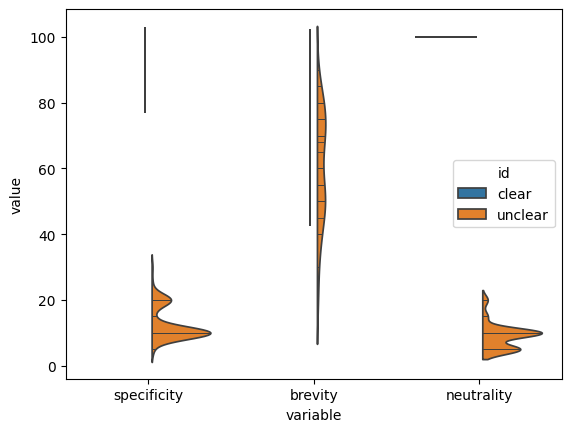

In [105]:
sns.violinplot(data=df_long, x='variable', y='value', hue='id', split=True, gap=0.1, inner='stick')

In [106]:
df

,specificity,brevity,neutrality,id
0,90,85,100,clear
1,90,85,100,clear
2,90,90,100,clear
3,90,85,100,clear
4,85,70,100,clear
...,...,...,...,...
195,10,70,10,unclear
196,10,50,10,unclear
197,10,55,10,unclear
198,10,50,10,unclear


## Understand Embedding Vectors

In [114]:
#Get the embedding vectors from OAI API
def fetch_oai_embeddings(input_strings:list,
                         embedding_model: str,
                         oai_client:OpenAI)-> list:

    responses = []

    #Get the embedding values for each input in your list
    #Probably a way to do this async
    for input_string in input_strings:
        response = oai_client.embeddings.create(
            input=input_string,
            model=embedding_model)
        responses.append(response.data[0].embedding)

    return responses

In [119]:
# set up a non-chat openai client
client = OpenAI()

In [120]:
sentence1 = fetch_oai_embeddings(['The cat sat on the mat'], 'text-embedding-ada-002', client)
sentence2 = fetch_oai_embeddings(['The mat was sat on by the cat'], 'text-embedding-ada-002', client)
sentence3 = fetch_oai_embeddings(['The horse sat on the mat'], 'text-embedding-ada-002', client)
sentence4 = fetch_oai_embeddings(['The horse ate the bus'], 'text-embedding-ada-002', client)

In [146]:

sentence5 = fetch_oai_embeddings(['Die Katze saß auf der Matte'], 'text-embedding-ada-002', client)

In [124]:

from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sentence1, sentence2)


array([[0.97210137]])

In [144]:
# function that receives a vector and returns the index values of that vector in order of the elements' value

v = sentence1[0]

v[:10]

s = pd.Series(v)
s = np.abs(s)

s.sort_values(ascending=False)[:10]

194     0.697716
954     0.232846
1120    0.165481
1246    0.109429
518     0.075850
1240    0.057594
1083    0.056515
475     0.053378
512     0.051089
1055    0.050549
dtype: float64

In [145]:
s = pd.Series(sentence2[0])
s = np.abs(s)

s.sort_values(ascending=False)[:10]

194     0.682597
954     0.234450
1120    0.163971
1246    0.106438
518     0.091951
475     0.064160
1055    0.062619
676     0.061797
1240    0.053476
1083    0.049340
dtype: float64

In [147]:
s = pd.Series(sentence3[0])
s = np.abs(s)

s.sort_values(ascending=False)[:10]

194     0.693073
954     0.231230
1120    0.164241
1246    0.103458
518     0.076786
1240    0.067348
1083    0.055910
1487    0.054268
512     0.052781
1055    0.050242
dtype: float64

In [148]:
s = pd.Series(sentence4[0])
s = np.abs(s)

s.sort_values(ascending=False)[:10]

194     0.672004
954     0.209498
1120    0.158231
1246    0.095684
518     0.086418
512     0.057813
1240    0.057410
1132    0.055900
1102    0.054238
1487    0.051543
dtype: float64

In [149]:
s = pd.Series(sentence5[0])
s = np.abs(s)

s.sort_values(ascending=False)[:10]

194     0.662423
954     0.211656
1120    0.151294
1487    0.103783
1201    0.069465
10      0.068540
1246    0.061287
475     0.058512
1387    0.053401
1519    0.053303
dtype: float64